In [ ]:
import torch
import matplotlib.pyplot as plt
import os

cthres = [8e-2, 1e-2, 1e-5, 1e-10, 1e-15, 1e-20, 1e-25, 1e-30, 1e-35]
num_layers = 38

results = []

for cthre in cthres:
    layer_results = []
    for layer_idx in range(num_layers):
        tA_prod_path = f"/data/kxia2/mamba_cleaned/artifacts/Zamba2-1.2B-thepile_new-clampTop0.01-max/tA_prod/tA_prod_layer_{layer_idx}.pt"

        if not os.path.exists(tA_prod_path):
            print(f"File not found: {tA_prod_path}")
            continue

        tA_prod = torch.load(tA_prod_path, map_location="cpu")
        channel_mask = tA_prod > cthre
        activation_ratio = (channel_mask.sum() / channel_mask.shape[0]) * 100
        layer_results.append(round(activation_ratio.item(), 2))
    results.append(layer_results)

plt.figure(figsize=(12, 6))
for idx, cthre in enumerate(cthres):
    plt.plot(range(num_layers), results[idx], label=f"cthre={cthre}")

plt.xlabel("Layer Index")
plt.ylabel("Global Ratio (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [1]:
## compute max bound
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import os
import random



root_path = "./artifacts"


for seed_idx, seed in enumerate([10,20,30,40,50,60,70,80,90,100]):
    for factor in ["0.05"]:
        ref_list_ = [d for d in os.listdir(root_path) if f"Zamba2-1.2B-4k-clampTop{factor}-" in d and "avg" not in d and "max" not in d]  # lambada0
        all_cnt = len(ref_list_)
        print(all_cnt)
        for num in [10]:
            random.seed(seed)
            ref_list = random.sample(ref_list_, num)
            all_cnt = len(ref_list)
            print(all_cnt)
            for layer in range(38):
                max_alpha = {}
                max_decay = None
                max_tA_prod = None
                for dir in ref_list:
                    alpha_path = os.path.join(root_path, dir, "alpha", f"alpha_layer_{layer}.pt")
                    decay_path = os.path.join(root_path, dir, "decay", f"decay_layer_{layer}.pt")
                    tA_prod_path = os.path.join(root_path, dir, "tA_prod", f"tA_prod_layer_{layer}.pt")
                    delta_thre_path = os.path.join(root_path, dir, "delta_t-thre", f"delta_t-thre_layer_{layer}.pt")
                    alpha = torch.load(alpha_path, map_location="cpu")
                    decay = torch.load(decay_path, map_location="cpu")
                    tA_prod = torch.load(tA_prod_path, map_location="cpu")
                    delta_thre = torch.load(delta_thre_path, map_location="cpu")

                    if max_decay is None:
                        max_alpha = {key: value.clone() for key, value in alpha.items()}
                        max_delta_thre = {key: value.clone() for key, value in delta_thre.items()}
                        max_decay = decay.clone()
                        max_tA_prod = tA_prod.clone()
                    else:
                        for key in alpha:
                            max_alpha[key] = torch.max(max_alpha[key], alpha[key])
                            max_delta_thre[key] = torch.max(max_delta_thre[key], delta_thre[key])
                        max_decay = torch.max(max_decay, decay)
                        max_tA_prod = torch.max(max_tA_prod, tA_prod)
                name = "Zamba2-1.2B-4k-clampTop0.05"+f"max{num}-{seed_idx}"
                os.makedirs(os.path.join(root_path, name, "alpha"), exist_ok=True)
                os.makedirs(os.path.join(root_path, name, "decay"), exist_ok=True)
                os.makedirs(os.path.join(root_path, name, "tA_prod"), exist_ok=True)
                os.makedirs(os.path.join(root_path, name, "delta_t-thre"), exist_ok=True)
                torch.save(max_alpha, os.path.join(root_path, name, "alpha", f"alpha_layer_{layer}.pt"))
                torch.save(max_decay, os.path.join(root_path, name, "decay", f"decay_layer_{layer}.pt"))
                torch.save(max_tA_prod, os.path.join(root_path, name, "tA_prod", f"tA_prod_layer_{layer}.pt"))
                torch.save(max_delta_thre, os.path.join(root_path, name, "delta_t-thre", f"delta_t-thre_layer_{layer}.pt"))
                # print(os.path.join(root_path, name, "delta_t-thre", f"delta_t-thre_layer_{layer}.pt"))

100
10
100
10
100
10
100
10
100
10
100
10
100
10
100
10
100
10
100
10


In [ ]:
import torch

for cthre in [1e-1, 1e-2, 1e-5, 1e-10, 1e-15, 1e-20]:
    for layer_idx in range(24):
        tA_prod_path = f"/data/kxia2/mamba_cleaned/artifacts/Zamba2-1.2B-thepile_new-clampTop0.15-avg/tA_prod/tA_prod_layer_{layer_idx}.pt"

        tA_prod = torch.load(tA_prod_path, map_location="cpu")
        channel_mask = tA_prod > cthre
        print("cthre", cthre, end=": ")
        print(f"{round((channel_mask.sum()/channel_mask.shape[0]).item() * 100, 1)}%", end=" ")
    print()

In [ ]:
import json
import os

best_ours = {}
second_ours = {}
init = False

result_dir = "/data/kxia2/mamba_cleaned/pred_ppl/subseq_lambada"
files = [i for i in os.listdir(result_dir) if "1.0.json" in i and "max" in i and "clampTop0.10" in i]

for name in files:
    result_path = os.path.join(result_dir, name)
    
    try:
        with open(result_path) as f:
            result = json.load(f)
    except Exception as e:
        print(f"Error opening or loading {result_path}: {e}")
        continue

    if not init:
        for key in result:
            best_ours[key] = str(1e10)
            best_ours[key + "_path"] = ""
            second_ours[key] = str(1e10)
            second_ours[key + "_path"] = ""
        init = True

    for key in result:
        current_ppl = float(result[key])
        best_ppl = float(best_ours[key])
        second_ppl = float(second_ours[key])

        if current_ppl < best_ppl:
            second_ours[key] = best_ours[key]
            second_ours[key + "_path"] = best_ours[key + "_path"]

            best_ours[key] = result[key]
            best_ours[key + "_path"] = name
        elif current_ppl < second_ppl and name != best_ours[key + "_path"]:
            second_ours[key] = result[key]
            second_ours[key + "_path"] = name


print("Ours best result and path:")
for key in best_ours:
    if not key.endswith("_path"):
        print(f"{key}: {best_ours[key]} (Path: {best_ours[key + '_path']})")

print("\nOurs second best result and path:")
for key in second_ours:
    if not key.endswith("_path"):
        print(f"{key}: {second_ours[key]} (Path: {second_ours[key + '_path']})")

In [8]:
import json
import os

results = []
result_dir = "/data/kxia2/mamba_cleaned/pred_longbench_e"
files = [i for i in os.listdir(result_dir)]

for name in files:
    if "ablation-clampTop0.05max5-4" not in name:
        continue
    result_path = os.path.join(result_dir, name, "result.json")

    try:
        with open(result_path) as f:
            result = json.load(f)
    except Exception as e:
        print(f"Error opening or loading {result_path}: {e}")
        continue
    try:    
        # Calculate average score
        result["avg"] = 0
        count = 0
        for key in result:
            # if key in ["gov_report", "qmsum", "multi_news", "vcsum"]:
            #     continue
            if key != "avg":
                result["avg"] += result[key]
                count += 1
    except Exception as e:
        print(f"Error opening or loading {result_path}: {e}")
        continue

    if count < 13:
        continue  # Skip if there are fewer than n keys

    result["avg"] /= count
    result["name"] = name  # Add the file name for tracking
    results.append(result)  # Append the entire result for sorting

# Sort results by "avg" in descending order
sorted_results = sorted(results, key=lambda x: x["avg"], reverse=True)

# Print results in order
print("Sorted results (Best to Last):")
for idx, result in enumerate(sorted_results):
    print(f"Rank {idx + 1}: {result['name']} (Average: {result['avg']:.4f})")
    for key in result:
        if key not in ["avg", "name"]:
            print(f"  {key}: {result[key]}")

import csv
csv_file = os.path.join(result_dir, "sorted_results.csv")
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write header
    if sorted_results:
        keys = [key for key in sorted_results[0] if key not in ["name", "avg"]]
        keys.sort()
        header = ["name"] + keys + (["avg"] if "avg" in sorted_results[0] else [])
        writer.writerow(header)
    
    # Write data rows
    for result in sorted_results:
        writer.writerow([result[key] for key in header])

print(f"Results saved to {csv_file}")

Sorted results (Best to Last):
Rank 1: mamba2-1.3b_ablation-clampTop0.05max5-4-0.05-1.0-dt_thre (Average: 16.9523)
  passage_count: 2.02
  samsum: 14.0
  2wikimqa: 5.73
  triviaqa: 48.74
  qasper: 5.14
  multi_news: 14.73
  hotpotqa: 5.52
  lcc: 40.92
  multifieldqa_en: 10.28
  gov_report: 14.33
  repobench-p: 33.79
  passage_retrieval_en: 3.51
  trec: 21.67
Rank 2: mamba2-1.3b_ablation-clampTop0.05max5-4-0.00075-1.0-dt_thre (Average: 16.0538)
  passage_count: 2.79
  samsum: 12.32
  2wikimqa: 4.26
  triviaqa: 42.48
  qasper: 4.63
  multi_news: 13.77
  hotpotqa: 4.75
  lcc: 41.18
  multifieldqa_en: 9.81
  gov_report: 13.79
  repobench-p: 33.38
  passage_retrieval_en: 5.87
  trec: 19.67
Rank 3: mamba2-1.3b_ablation-clampTop0.05max5-4-0.00025-1.0-dt_thre (Average: 15.9423)
  passage_count: 2.44
  samsum: 12.12
  2wikimqa: 4.76
  triviaqa: 42.77
  qasper: 4.64
  multi_news: 12.93
  hotpotqa: 4.43
  lcc: 42.49
  multifieldqa_en: 9.94
  gov_report: 14.19
  repobench-p: 34.12
  passage_retrie

In [7]:
import json
import os

results = []
result_dir = "/data/kxia2/mamba_cleaned/pred_ppl/subseq_lambada"
files = [i for i in os.listdir(result_dir)]

for name in files:
    result_path = os.path.join(result_dir, name)

    try:
        with open(result_path) as f:
            result = json.load(f)
    except Exception as e:
        print(f"Error opening or loading {result_path}: {e}")
        continue
    try:    
        # Calculate average score
        result["avg"] = 0
        count = 0
        for key in result:
            # if key in ["gov_report", "qmsum", "multi_news", "vcsum"]:
            #     continue
            if key != "avg":
                result["avg"] += float(result[key])
                count += 1
    except Exception as e:
        print(f"Error opening or loading {result_path}: {e}")
        continue

    result["avg"] /= count
    result["name"] = name  # Add the file name for tracking
    results.append(result)  # Append the entire result for sorting

# Sort results by "avg" in descending order
sorted_results = sorted(results, key=lambda x: -x["avg"], reverse=True)

# Print results in order
print("Sorted results (Best to Last):")
for idx, result in enumerate(sorted_results):
    print(f"Rank {idx + 1}: {result['name']} (Average: {result['avg']:.4f})")
    for key in result:
        if key not in ["avg", "name"]:
            print(f"  {key}: {result[key]}")

import csv
csv_file = os.path.join(result_dir, "sorted_results.csv")
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write header
    if sorted_results:
        header = ["name"] + [key for key in sorted_results[0] if key not in ["name"]]
        writer.writerow(header)
    
    # Write data rows
    for result in sorted_results:
        writer.writerow([result[key] for key in header])

print(f"Results saved to {csv_file}")

Error opening or loading /data/kxia2/mamba_cleaned/pred_ppl/subseq_lambada/sorted_results.csv: Expecting value: line 1 column 1 (char 0)
Sorted results (Best to Last):
Rank 1: Zamba2-1.2B_4k-clampTop0.05-avg-dt_thre-0.025-1.0.json (Average: 11.3455)
  40k: 11.4625
  30k: 9.8008
  20k: 11.5708
  10k: 12.4190
  2k: 11.4742
  average: 11.3455
Rank 2: Zamba2-1.2B_4k-clampTop0.05-avg-dt_thre-0.02-1.0.json (Average: 11.3469)
  40k: 11.4700
  30k: 9.7974
  20k: 11.5709
  10k: 12.4220
  2k: 11.4742
  average: 11.3469
Rank 3: Zamba2-1.2B_4k-clampTop0.05-avg-dt_thre-0.03-1.0.json (Average: 11.3508)
  40k: 11.4756
  30k: 9.7984
  20k: 11.5808
  10k: 12.4251
  2k: 11.4742
  average: 11.3508
Rank 4: Zamba2-1.2B_4k-clampTop0.05-avg-dt_thre-0.01-1.0.json (Average: 11.4267)
  40k: 11.8501
  30k: 9.8641
  20k: 11.6225
  10k: 12.3224
  2k: 11.4742
  average: 11.4267
Rank 5: Zamba2-1.2B_4k-clampTop0.10-avg-dt_thre-0.03-1.0.json (Average: 11.4313)
  40k: 11.7490
  30k: 9.9302
  20k: 11.6395
  10k: 12.3633

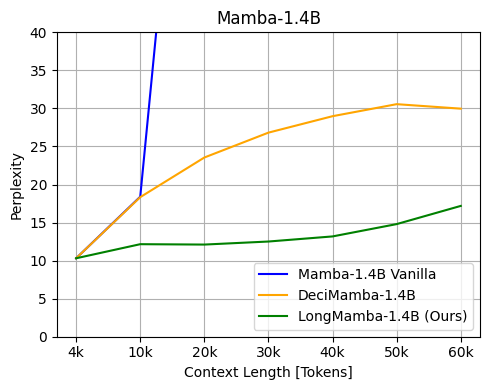

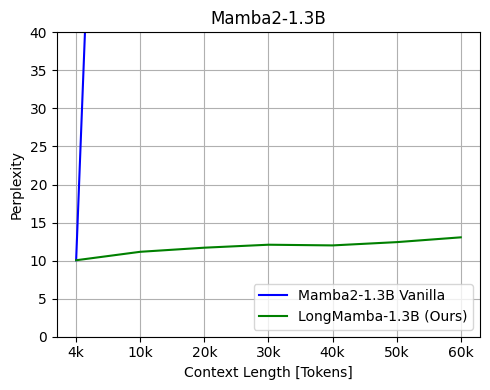

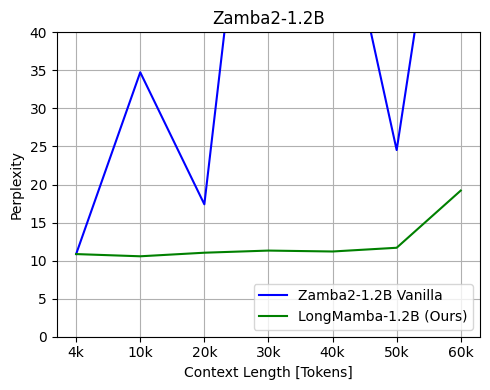

In [ ]:
import matplotlib.pyplot as plt

context_lengths = ["4k", "10k", "20k", "30k", "40k", "50k", "60k"]

mamba_vanilla = [10.31, 18.40, 105.19, 492.54, 1537.56, 3900.43, 7958.57]
mamba_decimamba = [10.31, 18.34, 23.55, 26.82, 28.98, 30.56, 29.97]
mamba_longmamba = [10.31, 12.16, 12.11, 12.51, 13.18, 14.80, 17.19]

mamba2_vanilla = [10.05, 227.65, 1980.04, 4213.87, 3851.41, 2343.61, 1531.66]
mamba2_longmamba = [10.05, 11.16, 11.70, 12.09, 12.00, 12.43, 13.06]

zamba2_vanilla = [10.86, 34.75, 17.40, 89.65, 63.01, 24.53, 79.69]
zamba2_longmamba = [10.86, 10.57, 11.04, 11.32, 11.20, 11.69, 19.21]

#Mamba-1.4B
plt.figure(figsize=(5, 4))
plt.plot(context_lengths, mamba_vanilla, label="Mamba-1.4B Vanilla", color="blue")
plt.plot(context_lengths, mamba_decimamba, label="DeciMamba-1.4B", color="orange")
plt.plot(context_lengths, mamba_longmamba, label="LongMamba-1.4B (Ours)", color="green")
plt.title("Mamba-1.4B")
plt.xlabel("Context Length [Tokens]")
plt.ylabel("Perplexity")
plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 40)
plt.tight_layout()
plt.show()

#Mamba2-1.3B
plt.figure(figsize=(5, 4))
plt.plot(context_lengths, mamba2_vanilla, label="Mamba2-1.3B Vanilla", color="blue")
plt.plot(context_lengths, mamba2_longmamba, label="LongMamba-1.3B (Ours)", color="green")
plt.title("Mamba2-1.3B")
plt.xlabel("Context Length [Tokens]")
plt.ylabel("Perplexity")
plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 40)
plt.tight_layout()
plt.show()

#Zamba2-1.2B
plt.figure(figsize=(5, 4))
plt.plot(context_lengths, zamba2_vanilla, label="Zamba2-1.2B Vanilla", color="blue")
plt.plot(context_lengths, zamba2_longmamba, label="LongMamba-1.2B (Ours)", color="green")
plt.title("Zamba2-1.2B")
plt.xlabel("Context Length [Tokens]")
plt.ylabel("Perplexity")
plt.legend(loc=4)
plt.grid(True)
plt.ylim(0, 40)
plt.tight_layout()
plt.show()


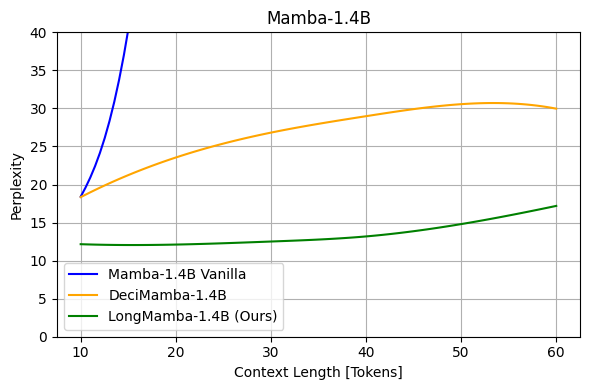

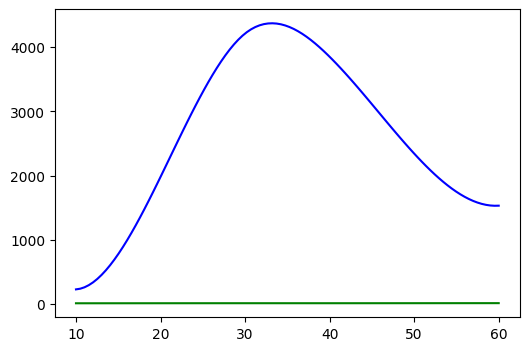

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 数据
context_lengths = [10, 20, 30, 40, 50, 60]

# Mamba-1.4B数据
mamba_vanilla = [18.40, 105.19, 492.54, 1537.56, 3900.43, 7958.57]
mamba_decimamba = [18.34, 23.55, 26.82, 28.98, 30.56, 29.97]
mamba_longmamba = [12.16, 12.11, 12.51, 13.18, 14.80, 17.19]

# Mamba2-1.3B数据
mamba2_vanilla = [227.65, 1980.04, 4213.87, 3851.41, 2343.61, 1531.66]
mamba2_longmamba = [11.09, 11.70, 12.11, 12.00, 12.43, 13.06]

# Zamba2-1.2B数据
zamba2_vanilla = [34.75, 17.40, 89.65, 63.01, 24.53, 79.69]
zamba2_longmamba = [10.57, 11.04, 11.32, 11.20, 11.69, 19.21]

# 插值函数
def interpolate_data(x_original, y_original):
    x_new = np.linspace(min(x_original), max(x_original), num=100) # 插值到100个点
    f_interp = interp1d(x_original, y_original, kind='cubic') # 三次插值
    y_new = f_interp(x_new)
    return x_new, y_new

# 绘制Mamba-1.4B图
plt.figure(figsize=(6, 4))
x_new_vanilla, y_new_vanilla = interpolate_data(context_lengths, mamba_vanilla)
x_new_decimamba, y_new_decimamba = interpolate_data(context_lengths, mamba_decimamba)
x_new_longmamba, y_new_longmamba = interpolate_data(context_lengths, mamba_longmamba)
plt.plot(x_new_vanilla, y_new_vanilla, label="Mamba-1.4B Vanilla", color="blue")
plt.plot(x_new_decimamba, y_new_decimamba, label="DeciMamba-1.4B", color="orange")
plt.plot(x_new_longmamba, y_new_longmamba, label="LongMamba-1.4B (Ours)", color="green")
plt.title("Mamba-1.4B")
plt.xlabel("Context Length [Tokens]")
plt.ylabel("Perplexity")
plt.legend()
plt.grid(True)
plt.ylim(0, 40) # Zoom in到Perplexity范围0-40
plt.tight_layout()
plt.show()

# 绘制Mamba2-1.3B图
plt.figure(figsize=(6, 4))
x_new_vanilla2_13b, y_new_vanilla2_13b = interpolate_data(context_lengths, mamba2_vanilla)
x_new_longmamba2_13b, y_new_longmamba2_13b = interpolate_data(context_lengths, mamba2_longmamba)
plt.plot(x_new_vanilla2_13b, y_new_vanilla2_13b,label="Mamba2-1.3B Vanilla", color="blue")
plt.plot(x_new_longmamba2_13b,y_new_longmamba2_13b,label="LongMamba-1 (Ours)",color='green')

